In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import re
import copy

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.4.5.post1 anndata==0.7.1 umap==0.3.9 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


In [2]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
results_prefix=DATA+'/'+PROTEIN+'/processed_data/A549.'+PROTEIN


In [3]:
bcldirs=['180515_SL-HXR_0665_AFCHH2H3CCXY','180515_SL-HXS_0555_AFCHGYTGCCXY',
        '180515_SL-HXR_0666_BFCHGY7FCCXY','180515_SL-HXS_0556_BFCHH2FNCCXY']

for channel in range(32):
    print(channel)
    channelname=str(channel+1)
    for bcldir in bcldirs:
        gbc_cbc_file='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/data/count_barcodes/mismatches2/'+bcldir+'/A549_'+PROTEIN+'_'+channelname+'.'+bcldir+'.variantBarcodeCounts.gz.with_cellbc_and_UMI.gz'
        cur_data=pd.read_csv(gbc_cbc_file,compression='gzip',sep='\t',header=None)
        cur_data.columns=['gbc','r2','pos','strand','cbc','umi','alignments','read_name']
        cur_data['cbc']=cur_data['cbc']+'ch'+str(channel)
        if channel==0:
            gbc_data=cur_data
        else:
            gbc_data=pd.concat([gbc_data,cur_data])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [4]:
import copy
gbc_data_original=copy.deepcopy(gbc_data)
gbc_data_original=gbc_data_original.drop_duplicates()
gbc_data_original.shape

(1017509, 8)

In [5]:
#keep only vbcs that map to - strand for vbcs, and to + strand for puro res
keep=[]
strand=list(gbc_data_original['strand'])
gbc=list(gbc_data_original['gbc'])
for i in range(gbc_data_original.shape[0]):
    cur_strand=strand[i]
    cur_gbc=gbc[i]
    if cur_strand=='-' and gbc!='Puro_res':
        keep.append(i)
    else:
        if cur_strand=='+' and gbc=='Puro_res':
            keep.append(i)
print('keep',len(keep),'total',gbc_data_original.shape[0])

gbc_data_filtered=copy.deepcopy(gbc_data_original)
gbc_data_filtered=gbc_data_filtered.iloc[keep,:]

keep 580666 total 1017509


In [6]:
def compute_TPT(gbcs_dataset):
    
    '''
    input: pandas data frame with the columns "cbc", "umi", "gbc", "r2" where every row is a read 
    output: pandas data frame with the columns "gbc", "cbc", "umi", "cbc-umi-r2-count", "cbc-umi-count", "TPT"
    NOTE: for the input, multiple reads corresponding to the same cbc-umi combination should be listed as separate lines!
    '''

    import copy
    import re
    import time

    print("======== annotating cbc-umi pairs, and cbc-umi-r2")
    gbcs_dataset['cbcumi']=[x+'-'+y for x,y in zip(gbcs_dataset['cbc'],gbcs_dataset['umi'])]
    cbcumir2=list([x+'+'+y for x,y in zip(gbcs_dataset['cbcumi'],gbcs_dataset['r2'])])
    gbcs_dataset['cbcumir2']=list([x+'_gbc_'+y for x,y in zip(cbcumir2,gbcs_dataset['gbc'])])

    print("======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi")
    cbcumi_group=gbcs_dataset.groupby('cbcumi').size()
    cbcumi_r2_group=gbcs_dataset.groupby('cbcumir2').size()
    cbcumi_from_grouped_reads=[x.split('+')[0] for x in cbcumi_r2_group.index]

    print("======== computing TPT")
    #divide every cbc-umi-r2 value by the cbc-umi values 
    combo_counts=pd.DataFrame({'cbc-umi-r2':cbcumi_r2_group,
                              'cbc-umi-r2-name':cbcumi_r2_group.index,
                              'cbc-umi':cbcumi_from_grouped_reads})
    combo_counts['cbc-umi-total']=copy.deepcopy(list(cbcumi_group.loc[combo_counts['cbc-umi']]))
    combo_counts['TPT']=1.0*combo_counts['cbc-umi-r2']/combo_counts['cbc-umi-total']
    
    combo_counts['gbc']=list([x.split('_gbc_')[1] for x in list(combo_counts.loc[:,'cbc-umi-r2-name'])])
    combo_counts['umi']=list([x.split('-')[1] for x in list(combo_counts['cbc-umi'])])
    combo_counts['cbc']=list([x.split('-')[0] for x in list(combo_counts['cbc-umi'])])
    
    print("======== compiling the final result")
    to_return=pd.DataFrame({'gbc':combo_counts['gbc'],
                           'cbc':combo_counts['cbc'],
                           'umi':combo_counts['umi'],
                           'cbc-umi-r2-count':combo_counts['cbc-umi-r2'],
                           'cbc-umi-count':combo_counts['cbc-umi-total'],
                           'TPT':combo_counts['TPT']})
    to_return=to_return.reset_index(drop=True)
    return(to_return)

gbc_data=compute_TPT(gbc_data_filtered)

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result


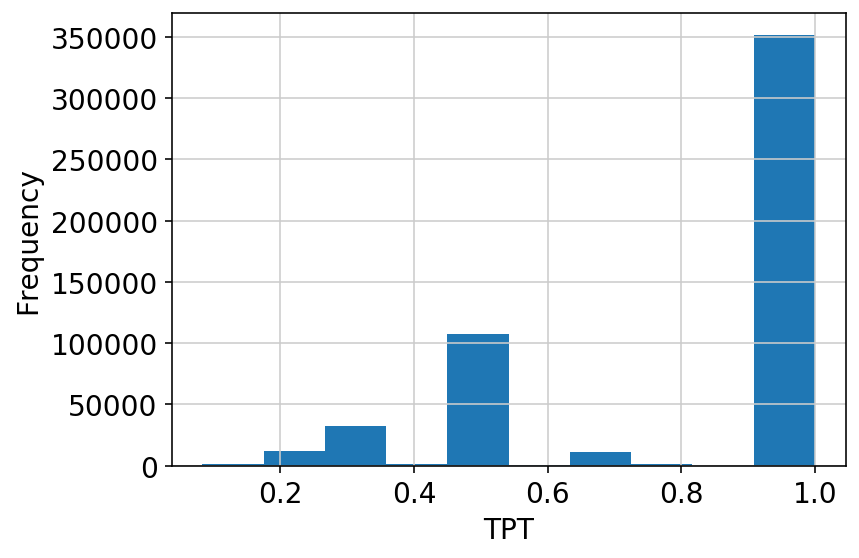

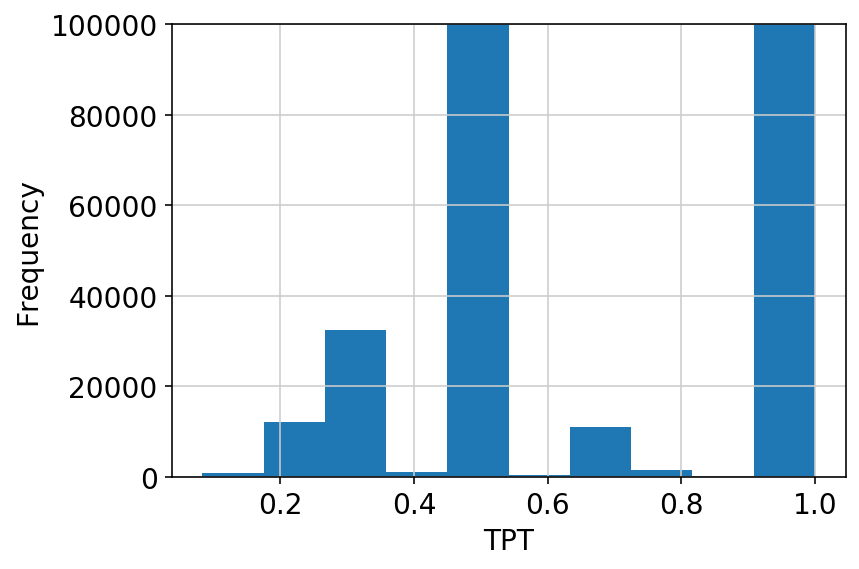

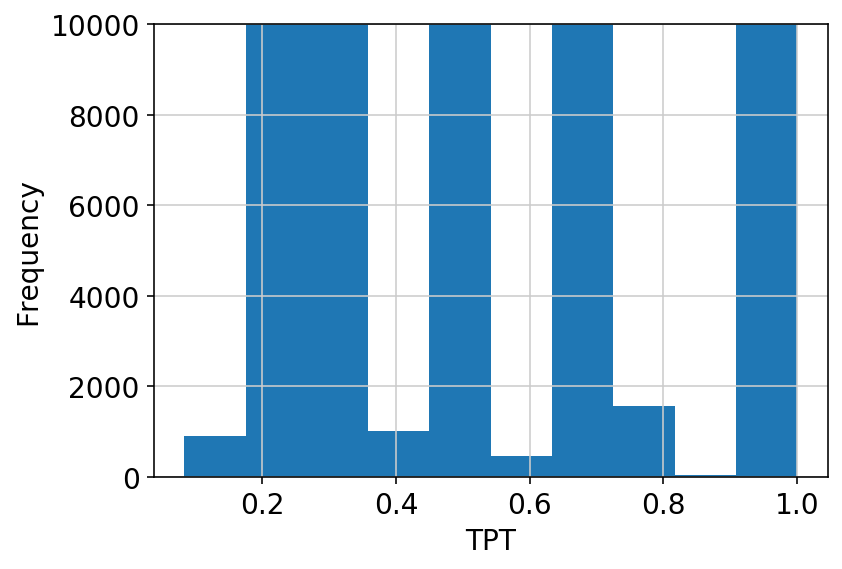

In [7]:
plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,100000)
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,10000)
plt.show()

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result


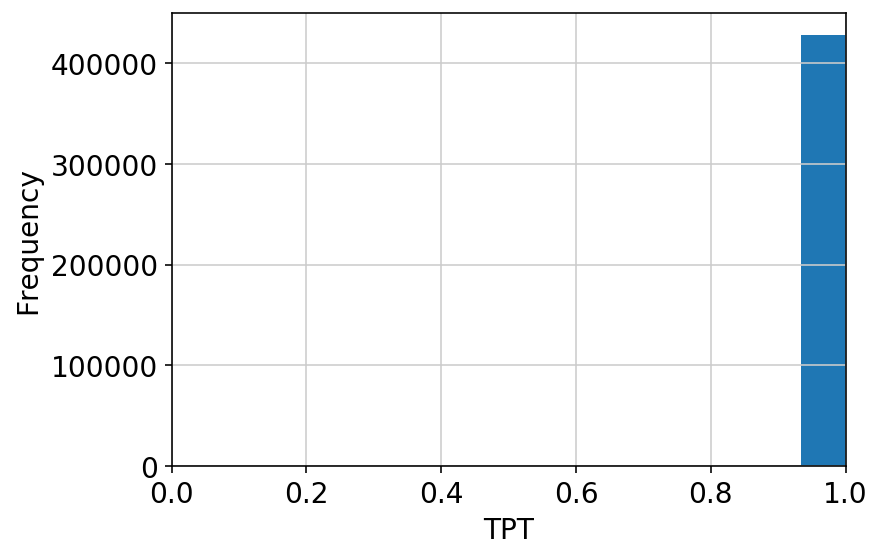

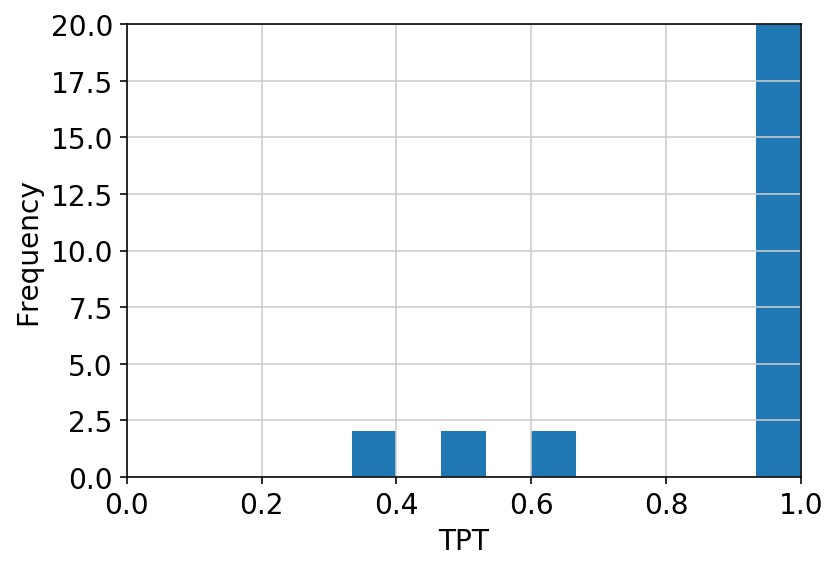

count    428350.000000
mean          0.999993
std           0.001939
min           0.333333
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: TPT, dtype: float64


In [8]:
#now, compute lenient TPT that only looks at whether reads mapped to the same gbc, 
#even if they have diff sequences

gbc_data_filtered_lenient=copy.deepcopy(gbc_data_filtered)
gbc_data_filtered_lenient['r2']=gbc_data_filtered_lenient['gbc']
gbc_data=compute_TPT(gbc_data_filtered_lenient)

plt.hist(gbc_data['TPT'],10)
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

plt.hist(gbc_data['TPT'],10)
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,20)
plt.xlim(0,1)
plt.show()

print(gbc_data['TPT'].describe())

In [9]:
#quickly look at the reads with bad TPTs
#there are v few of them (yay!)

gbc_data.loc[gbc_data['TPT']<1,:].head()

,gbc,cbc,umi,cbc-umi-r2-count,cbc-umi-count,TPT
43138,KRAS_G60D,ACGTCAATCAACACCAch8,AAACTTTTTC,2,3,0.666667
43139,KRAS_L159S,ACGTCAATCAACACCAch8,AAACTTTTTC,1,3,0.333333
52253,KRAS_G60D,AGAATAGTCCTCCTAGch31,CACTCCTAGT,2,3,0.666667
52254,KRAS_p.Thr158Thr.474AG,AGAATAGTCCTCCTAGch31,CACTCCTAGT,1,3,0.333333
124204,KRAS_Q61L,CATATTCCACGGCGTTch28,TACGGAATTG,1,2,0.500000


In [10]:
gbc_data_filtered.loc[gbc_data_filtered['cbc']=="ACGTCAATCAACACCAch8",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name,cbcumi,cbcumir2
244,KRAS_G60D,CCTCTAGGTTAATTAACACCACGCTAGCTTCTCCTCGTTACTCAGC...,56,-,ACGTCAATCAACACCAch8,CCTATCATGA,0,E00173:665:HH2H3CCXY:6:1115:9607:22141,ACGTCAATCAACACCAch8-CCTATCATGA,ACGTCAATCAACACCAch8-CCTATCATGA+CCTCTAGGTTAATTA...
3909,KRAS_G60D,ACGCTAGCTTCTCCTCGTTACTCAGCCCGGGCATTTTGTCTTACAT...,76,-,ACGTCAATCAACACCAch8,AAACTTTTTC,0,E00173:665:HH2H3CCXY:6:1211:25469:40759,ACGTCAATCAACACCAch8-AAACTTTTTC,ACGTCAATCAACACCAch8-AAACTTTTTC+ACGCTAGCTTCTCCT...
4727,KRAS_G60D,AGGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGT...,19,-,ACGTCAATCAACACCAch8,ATCGGTGCTT,0,E00173:665:HH2H3CCXY:6:2202:28737:44521,ACGTCAATCAACACCAch8-ATCGGTGCTT,ACGTCAATCAACACCAch8-ATCGGTGCTT+AGGCACAGTCGAGGC...
3717,KRAS_G60D,TCTAGGTTAATTAACACCACGCTAGCTTCTCCTCGTTACTCAGCCC...,58,-,ACGTCAATCAACACCAch8,ATCGGTGCTT,0,E00342:555:HGYTGCCXY:6:1216:7121:63929,ACGTCAATCAACACCAch8-ATCGGTGCTT,ACGTCAATCAACACCAch8-ATCGGTGCTT+TCTAGGTTAATTAAC...
3718,KRAS_G60D,TCTAGGTTAATTAACACCACGCTAGCTTCTCCTCGTTACTCAGCCC...,58,-,ACGTCAATCAACACCAch8,ATCGGTGCTT,0,E00342:555:HGYTGCCXY:6:1216:7172:64052,ACGTCAATCAACACCAch8-ATCGGTGCTT,ACGTCAATCAACACCAch8-ATCGGTGCTT+TCTAGGTTAATTAAC...
4883,KRAS_L159S,GGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCGTGGTTCGAC...,53,-,ACGTCAATCAACACCAch8,AAACTTTTTC,0,E00342:555:HGYTGCCXY:6:2224:11891:32109,ACGTCAATCAACACCAch8-AAACTTTTTC,ACGTCAATCAACACCAch8-AAACTTTTTC+GGCCCTCTAGGTTAA...
2087,KRAS_G60D,GGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCTCGTTACTC...,53,-,ACGTCAATCAACACCAch8,GTAGTTTGGC,0,E00173:666:HGY7FCCXY:6:1202:25611:8306,ACGTCAATCAACACCAch8-GTAGTTTGGC,ACGTCAATCAACACCAch8-GTAGTTTGGC+GGCCCTCTAGGTTAA...
2148,KRAS_G60D,GTTAATTAACACCACGCTAGCTTCTCCTCGTTACTCAGCCCGGGCA...,63,-,ACGTCAATCAACACCAch8,TTGTTTAATT,0,E00173:666:HGY7FCCXY:6:1205:15240:53100,ACGTCAATCAACACCAch8-TTGTTTAATT,ACGTCAATCAACACCAch8-TTGTTTAATT+GTTAATTAACACCAC...
6797,KRAS_G60D,GATGGCTGGCAACTAGAAGGCACAGTCGAGGCTGATCAGCGGGTTT...,2,-,ACGTCAATCAACACCAch8,ATCGGTGCTT,0,E00173:666:HGY7FCCXY:6:2104:14103:27292,ACGTCAATCAACACCAch8-ATCGGTGCTT,ACGTCAATCAACACCAch8-ATCGGTGCTT+GATGGCTGGCAACTA...
6237,KRAS_G60D,CTAGAAGGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTC...,14,-,ACGTCAATCAACACCAch8,AAACTTTTTC,0,E00342:556:HH2FNCCXY:6:2116:3234:69537,ACGTCAATCAACACCAch8-AAACTTTTTC,ACGTCAATCAACACCAch8-AAACTTTTTC+CTAGAAGGCACAGTC...


In [11]:
#really looks like a chimera

In [12]:
gbc_data_filtered.loc[gbc_data_filtered['cbc']=="AGAATAGTCCTCCTAGch31",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name,cbcumi,cbcumir2
2504,KRAS_G60D,TAAACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCTCG...,47,-,AGAATAGTCCTCCTAGch31,TCTCAAGAAA,0,E00173:665:HH2H3CCXY:8:1214:22698:22563,AGAATAGTCCTCCTAGch31-TCTCAAGAAA,AGAATAGTCCTCCTAGch31-TCTCAAGAAA+TAAACGGGCCCTCT...
6438,KRAS_G60D,GAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATTAACAC...,29,-,AGAATAGTCCTCCTAGch31,TCCGCCAAAA,0,E00173:665:HH2H3CCXY:8:1214:16336:35309,AGAATAGTCCTCCTAGch31-TCCGCCAAAA,AGAATAGTCCTCCTAGch31-TCCGCCAAAA+GAGGCTGATCAGCG...
7598,KRAS_G60D,GGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTT...,20,-,AGAATAGTCCTCCTAGch31,TTCAGGCCGC,0,E00173:665:HH2H3CCXY:8:2203:16498:2751,AGAATAGTCCTCCTAGch31-TTCAGGCCGC,AGAATAGTCCTCCTAGch31-TTCAGGCCGC+GGCACAGTCGAGGC...
7717,KRAS_G60D,GCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATCAACACCAC...,32,-,AGAATAGTCCTCCTAGch31,CACTCCTAGT,0,E00173:665:HH2H3CCXY:8:2206:25489:51975,AGAATAGTCCTCCTAGch31-CACTCCTAGT,AGAATAGTCCTCCTAGch31-CACTCCTAGT+GCTGATCAGCGGGT...
2277,KRAS_G60D,CTGGCAACTAGAAGGCACAGTCGAGGCTGATCAGCGGGTTTAAACG...,7,-,AGAATAGTCCTCCTAGch31,TAGATCACCT,0,E00173:666:HGY7FCCXY:8:1109:12225:37014,AGAATAGTCCTCCTAGch31-TAGATCACCT,AGAATAGTCCTCCTAGch31-TAGATCACCT+CTGGCAACTAGAAG...
3344,KRAS_G60D,GAAGGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAG...,17,-,AGAATAGTCCTCCTAGch31,CACTCCTAGT,0,E00173:666:HGY7FCCXY:8:2104:8897:39616,AGAATAGTCCTCCTAGch31-CACTCCTAGT,AGAATAGTCCTCCTAGch31-CACTCCTAGT+GAAGGCACAGTCGA...
5341,KRAS_G60D,AGATGGCTGGCAACTAGAAGGCACAGTCGAGGCTGATCAGCGGGTT...,1,-,AGAATAGTCCTCCTAGch31,CTCTACTTGG,0,E00173:666:HGY7FCCXY:8:1219:20212:25851,AGAATAGTCCTCCTAGch31-CTCTACTTGG,AGAATAGTCCTCCTAGch31-CTCTACTTGG+AGATGGCTGGCAAC...
5972,KRAS_G60D,CGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATTAACA...,28,-,AGAATAGTCCTCCTAGch31,ACCGGAAAGG,0,E00173:666:HGY7FCCXY:8:2201:18233:38456,AGAATAGTCCTCCTAGch31-ACCGGAAAGG,AGAATAGTCCTCCTAGch31-ACCGGAAAGG+CGAGGCTGATCAGC...
5973,KRAS_G60D,CGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATTAACA...,28,-,AGAATAGTCCTCCTAGch31,ACCGGAAAGG,0,E00173:666:HGY7FCCXY:8:2201:18233:41022,AGAATAGTCCTCCTAGch31-ACCGGAAAGG,AGAATAGTCCTCCTAGch31-ACCGGAAAGG+CGAGGCTGATCAGC...
3691,KRAS_G60D,TTATACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCTC...,46,-,AGAATAGTCCTCCTAGch31,AAATTCTTTT,0,E00342:556:HH2FNCCXY:8:2220:28209:31511,AGAATAGTCCTCCTAGch31-AAATTCTTTT,AGAATAGTCCTCCTAGch31-AAATTCTTTT+TTATACGGGCCCTC...


In [13]:
#same here

Filter to keep TPT==1
==

In [14]:
outpath=results_prefix+'.anno'
gbc_data.to_csv(outpath+'.vbc_TPT.gz',compression='gzip',index=False)

In [15]:
TPT_threshold=1.0

counts_with_tpt=pd.read_csv(outpath+'.vbc_TPT.gz',compression='gzip')
print(counts_with_tpt.head())

keep=list([x>=TPT_threshold for x in counts_with_tpt['TPT']])
filtered=counts_with_tpt[keep]
print(filtered.shape)
print(filtered.head())

                   gbc                   cbc         umi  cbc-umi-r2-count  \
0            KRAS_T50P  AAAACAATCGGATGTTch20  ATAGGGCACC                 1   
1            KRAS_L79I  AAAACCTGTCCTTGCCch18  ATGGTATCTT                 1   
2            KRAS_P34L  AAAACGGGGTGGGTCAch31  AACGTATCAA                 1   
3            KRAS_I36M  AAAAGATGCACGTGAGch27  AGCCATCGCA                 1   
4  KRAS_p.Al66Al.198AG  AAAAGCAATCGTACGGch15  CCCATTGTTG                 1   

   cbc-umi-count  TPT  
0              1  1.0  
1              1  1.0  
2              1  1.0  
3              1  1.0  
4              1  1.0  
(428344, 6)
                   gbc                   cbc         umi  cbc-umi-r2-count  \
0            KRAS_T50P  AAAACAATCGGATGTTch20  ATAGGGCACC                 1   
1            KRAS_L79I  AAAACCTGTCCTTGCCch18  ATGGTATCTT                 1   
2            KRAS_P34L  AAAACGGGGTGGGTCAch31  AACGTATCAA                 1   
3            KRAS_I36M  AAAAGATGCACGTGAGch27  AGCCATCGCA       

In [16]:
filtered_counts=filtered.groupby(['cbc','gbc','umi']).sum()
print(filtered_counts.shape)
filtered_counts.head()

filtered_counts.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_counts.gz',compression='gzip')

filtered_counts=pd.read_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_counts.gz',compression='gzip')
print(filtered_counts.shape)
filtered_counts.head()

#go through each line, make 2 matrices
#one gives us the total reads per cbc-gbc, one gives us the umis.

umi_counts={}
read_counts={}
for i in range(filtered_counts.shape[0]):
    if i%100000==0:
        print(i)
    cbc=filtered_counts.loc[i,'cbc']
    gbc=filtered_counts.loc[i,'gbc']
    umi=filtered_counts.loc[i,'umi']
    count=filtered_counts.loc[i,'cbc-umi-count']
    if cbc not in umi_counts:
        umi_counts[cbc]={}
        read_counts[cbc]={}
    if gbc not in umi_counts[cbc]:
        umi_counts[cbc][gbc]=set()
        read_counts[cbc][gbc]=0
    umi_counts[cbc][gbc].add(umi)
    read_counts[cbc][gbc]+=count
    
cbcs=list(set(filtered_counts['cbc']))
gbcs=list(set(filtered_counts['gbc']))
m_reads=np.zeros((len(cbcs),len(gbcs)))
m_umis=np.zeros((len(cbcs),len(gbcs)))
for cbc_idx in range(len(cbcs)):
    if cbc_idx%10000==0:
        print(cbc_idx)
    cbc=cbcs[cbc_idx]
    for gbc_idx in range(len(gbcs)):
        gbc=gbcs[gbc_idx]
        if cbc in umi_counts:
            if gbc in umi_counts[cbc]:
                count=len(list(umi_counts[cbc][gbc]))
                m_umis[cbc_idx,gbc_idx]=count
                m_reads[cbc_idx,gbc_idx]=read_counts[cbc][gbc]

(428344, 3)
(428344, 6)
0
100000
200000
300000
400000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [17]:
m_umis_df=pd.DataFrame(m_umis)
m_umis_df.index=cbcs
m_umis_df.columns=gbcs

m_reads_df=pd.DataFrame(m_reads)
m_reads_df.index=cbcs
m_reads_df.columns=gbcs

m_umis_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.gz',compression='gzip')
m_reads_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_read_counts.gz',compression='gzip')

In [18]:
m_umis_df=pd.read_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.gz',compression='gzip',index_col=0)
m_reads_df=pd.read_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_read_counts.gz',compression='gzip',index_col=0)
print(m_umis_df.shape)
m_umis_df.head()

(153365, 100)


,KRAS_G60D,KRAS_Q99E,KRAS_L159S,KRAS_R164Q,KRAS_p.Lys179Ar.536AG,KRAS_p.Al66Al.198AG,KRAS_T158A,KRAS_Q22H,KRAS_T50P,KRAS_p.Me170Leu.508AT,...,KRAS_K147T,KRAS_p.Gly75Al.224GC,KRAS_p.Thr158Thr.474AG,KRAS_G13R,KRAS_Q61K,KRAS_G12V,KRAS_R135T,KRAS_p.Vl112Ile.334GA,KRAS_D119G,KRAS_G12Y
GCGCCAATCCAGAAGGch14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NGTCACTTCTTCTGGCch6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GNTCTGTCCTATGTTTch3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTATCCAGCGATGACch3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAAATGACAGCATGAGch24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


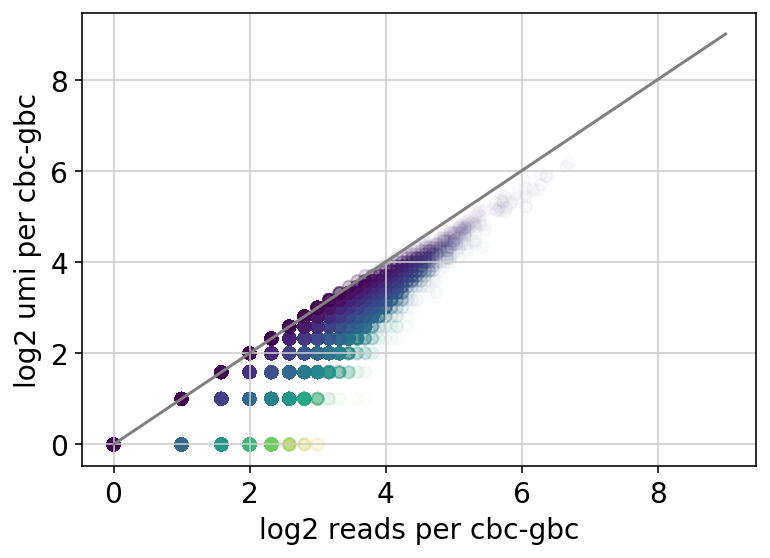

In [19]:
plt.scatter(np.log2(m_reads.flatten()[m_reads.flatten()>0.0]),
            np.log2(m_umis.flatten()[m_umis.flatten()>0.0]),alpha=0.02,
            c=np.log2(m_reads.flatten()[m_reads.flatten()>0.0])-np.log2(m_umis.flatten()[m_umis.flatten()>0.0]))
plt.xlabel('log2 reads per cbc-gbc')
plt.ylabel('log2 umi per cbc-gbc')
plt.plot(np.arange(0, 10), np.arange(0, 10),color='gray')
plt.show()

Annotate cells
==

In [20]:
#read in data
adata=sc.read(results_prefix+'.raw.h5ad')
adata

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


AnnData object with n_obs × n_vars = 192000 × 33694 
    obs: 'batch'

In [21]:
anno_cells=[]
cell_names=list(m_umis_df.index)
for i in range(m_umis_df.shape[0]):
    if i%10000==0:
        print(i)
    anno_cell=re.sub('ch','-1-',cell_names[i])
    anno_cells.append(anno_cell)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [22]:
anno_cells_adata=list(set(adata.obs_names).intersection(set(anno_cells)))
print('annotated',len(anno_cells_adata),'total',len(adata.obs_names))

annotated 119968 total 192000


In [23]:
#now, go ahead and annotate the cells
m_umis_df.index=anno_cells
cell_names=list(m_umis_df.index)

anno_df=pd.DataFrame(np.zeros((len(adata.obs_names),len(m_umis_df.columns))))
anno_df.index=list(adata.obs_names)
anno_df.columns=list(m_umis_df.columns)

anno_df.loc[anno_cells_adata,:]=m_umis_df.loc[anno_cells_adata,list(m_umis_df)]
anno_df.sum()

KRAS_G60D                 4249.0
KRAS_Q99E                 5727.0
KRAS_L159S                7059.0
KRAS_R164Q                3730.0
KRAS_p.Lys179Ar.536AG     5222.0
KRAS_p.Al66Al.198AG       7132.0
KRAS_T158A                5181.0
KRAS_Q22H                 3800.0
KRAS_T50P                 3673.0
KRAS_p.Me170Leu.508AT     5461.0
KRAS_G12A                 5225.0
KRAS_G13E                 2816.0
KRAS_R41K                 5797.0
KRAS_A59G                 4897.0
KRAS_I36M                 6578.0
KRAS_p.Vl8Vl.24AG         6773.0
KRAS_G12S                 2172.0
KRAS_Q25H                 4354.0
KRAS_V14L                 3858.0
KRAS_p.Thr50Thr.150CG     4879.0
KRAS_G12C                 4033.0
KRAS_P110S                3320.0
KRAS_A146V                3717.0
KRAS_p.Cys185Tyr.554GA    4170.0
KRAS_R149K                3801.0
KRAS_K5E                  1995.0
KRAS_L79I                 3954.0
KRAS_p.Lys88Lys.264AG     3978.0
KRAS_p.Al130VlCT          4336.0
KRAS_E63K-                4624.0
          

In [24]:
for gbc in list(m_umis_df.columns):
    adata.obs[gbc]=anno_df[gbc]

In [25]:
#also, annotate each cell with the mutant it has
gbcs=['KRAS_E63K-', 'KRAS_p.Thr158Thr.474AG', 'KRAS_P34R', 'KRAS_T74A', 'KRAS_D119G', 'KRAS_p.Al66Al.198AG', 'KRAS_L79I', 'KRAS_p.Thr144Thr.432AG', 'KRAS_G12V', 'KRAS_K147T', 'KRAS_p.Thr127Thr.381AG', 'KRAS_P34L', 'KRAS_WT', 'KRAS_K5E', 'KRAS_R135T', 'KRAS_p.Vl112Ile.334GA', 'KRAS_G12I', 'KRAS_AG59GV', 'KRAS_G12A', 'KRAS_Q61R', 'KRAS_K117R', 'KRAS_L19F', 'KRAS_T58I', 'KRAS_Q25H', 'KRAS_I163S', 'KRAS_T50P', 'KRAS_p.Lys88Lys.264AG', 'KRAS_T20M', 'KRAS_V14L', 'KRAS_A59E', 'KRAS_M111L', 'KRAS_R41K', 'KRAS_p.Phe141Leu', 'KRAS_G60S', 'KRAS_A59G', 'KRAS_H166Y', 'KRAS_Q61K', 'KRAS_p.Lys178Lys.534AG', 'KRAS_G12D', 'KRAS_G13R', 'KRAS_Q99E', 'KRAS_T20R', 'KRAS_R149K', 'TP53_p.Pro295Pro', 'KRAS_G12R', 'KRAS_T158A', 'KRAS_p.Cys185Tyr.554GA', 'KRAS_p.Ser136AsnGA', 'KRAS_A59T', 'KRAS_P110S', 'KRAS_C118S', 'KRAS_G12S', 'KRAS_G12F', 'KRAS_G60V', 'KRAS_G60D', 'KRAS_p.Ser17Ser.51TC', 'KRAS_Q61A', 'KRAS_p.Lys169Lys.507GA', 'KRAS_R68S', 'KRAS_I36M', 'KRAS_p.Gly75Al.224GC', 'KRAS_p.Asp30Asp.90CT', 'KRAS_L52F', 'KRAS_R164Q', 'KRAS_A146V', 'KRAS_Q22H', 'KRAS_L159S', 'KRAS_N26Y', 'KRAS_AG11TD', 'KRAS_T50I', 'KRAS_Q22K', 'KRAS_K117N', 'KRAS_p.Thr20Thr.60GA', 'KRAS_p.Thr74Thr.222TC', 'KRAS_p.Vl8Vl.24AG', 'KRAS_Q61P', 'KRAS_p.Lys179Ar.536AG', 'KRAS_G13E', 'KRAS_A146P', 'KRAS_E31K', 'KRAS_G12C', 'KRAS_A146T', 'KRAS_G12Y', 'KRAS_p.Thr50Thr.150CG', 'KRAS_p.Gly77Al.230GC', 'KRAS_p.Al155Gly.464CG', 'KRAS_Q61L', 'KRAS_p.Asp173Asp.519TC', 'KRAS_p.Me170Leu.508AT', 'KRAS_T144P', 'KRAS_K147N', 'KRAS_D57N', 'KRAS_p.Al130VlCT', 'KRAS_Q61H', 'KRAS_D33E', 'KRAS_G13C', 'KRAS_V14I', 'KRAS_G13V', 'KRAS_K176Q']
mutant=[]
for cell_idx in range(len(adata.obs_names)):
    if cell_idx%10000==0:
        print(cell_idx)
    cur_mutants=[]
    for gbc in gbcs:
        if adata.obs[gbc][cell_idx]>0:
            cur_mutants.append(gbc)
    if len(cur_mutants)==0:
        mutant.append('uninfected')
    elif len(cur_mutants)==1:
        mutant.append(cur_mutants[0])
    elif len(cur_mutants)>1:
        mutant.append('multiple')
    else:
        mutant.append('unannotated')
        

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [26]:
adata.obs['mutant']=mutant
adata

AnnData object with n_obs × n_vars = 192000 × 33694 
    obs: 'batch', 'KRAS_G60D', 'KRAS_Q99E', 'KRAS_L159S', 'KRAS_R164Q', 'KRAS_p.Lys179Ar.536AG', 'KRAS_p.Al66Al.198AG', 'KRAS_T158A', 'KRAS_Q22H', 'KRAS_T50P', 'KRAS_p.Me170Leu.508AT', 'KRAS_G12A', 'KRAS_G13E', 'KRAS_R41K', 'KRAS_A59G', 'KRAS_I36M', 'KRAS_p.Vl8Vl.24AG', 'KRAS_G12S', 'KRAS_Q25H', 'KRAS_V14L', 'KRAS_p.Thr50Thr.150CG', 'KRAS_G12C', 'KRAS_P110S', 'KRAS_A146V', 'KRAS_p.Cys185Tyr.554GA', 'KRAS_R149K', 'KRAS_K5E', 'KRAS_L79I', 'KRAS_p.Lys88Lys.264AG', 'KRAS_p.Al130VlCT', 'KRAS_E63K-', 'KRAS_P34L', 'KRAS_I163S', 'KRAS_T74A', 'KRAS_T144P', 'KRAS_p.Asp173Asp.519TC', 'KRAS_Q22K', 'KRAS_Q61L', 'KRAS_V14I', 'KRAS_H166Y', 'KRAS_Q61A', 'KRAS_AG59GV', 'KRAS_p.Thr20Thr.60GA', 'KRAS_K117R', 'KRAS_E31K', 'KRAS_A59T', 'KRAS_p.Gly77Al.230GC', 'KRAS_T20R', 'KRAS_A146T', 'KRAS_p.Thr144Thr.432AG', 'KRAS_p.Lys178Lys.534AG', 'KRAS_P34R', 'KRAS_p.Asp30Asp.90CT', 'KRAS_K147N', 'KRAS_G12I', 'KRAS_T58I', 'KRAS_p.Al155Gly.464CG', 'KRAS_p.Thr74Thr.

In [29]:
adata.write(results_prefix+'.raw.anno.h5ad')

In [30]:
print(mutant.count('uninfected'))
print(mutant.count('unannotated'))
print(mutant.count('multiple'))


72397
0
12453
